# Необходимые библиотеки

In [84]:
import pandas as pd
import numpy as np

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
import warnings

In [87]:
warnings.filterwarnings('ignore')

# Загрузка данных

In [88]:
data = pd.read_csv('hh ru DATASET.csv')
data.head()

,vacancy_id,employer_id,employees_number,creation_date,work_schedule,employment,length_of_employment,compensation_from,compensation_to,accept_teenagers,...,young_response_count,young_female_response_count,young_male_response_count,invitation_count,female_invitation_count,male_invitation_count,young_invitation_count,young_female_invitation_count,young_male_invitation_count,industry_id_list
0,77424192,2571258,300,2023-02-27,full_day,full,up_to_3_years,35000.0,0.0,False,...,4,4,0,21,21,0,0,0,0,[48]
1,78161908,4809555,50,2023-03-17,shift,full,no_experience,22500.0,NaN,False,...,5,4,1,26,26,0,2,2,0,[None]
2,79496395,5667513,5,2023-04-19,shift,full,up_to_3_years,24000.0,30000.0,False,...,2,2,0,3,3,0,0,0,0,[None]
3,87102246,1072323,0,2023-09-21,full_day,full,up_to_3_years,50000.0,NaN,False,...,0,0,0,9,7,2,0,0,0,"[7, 8]"
4,76367381,1160192,0,2023-01-30,full_day,full,up_to_3_years,55000.0,150000.0,False,...,0,0,0,49,39,10,0,0,0,"[5, 13]"


In [89]:
original_shape = data.shape

# Обработка выбросов

#### Сначала проведём обработку выбросов, чтобы они не влияли на заполнение пропусков в дальнейшем

#### Посмотрим на число грубых выбросов по столбцам

In [90]:
num_cols = data.select_dtypes('number').columns.drop(['vacancy_id', 'employer_id'])

#### Посмотрим некоторые боксплоты

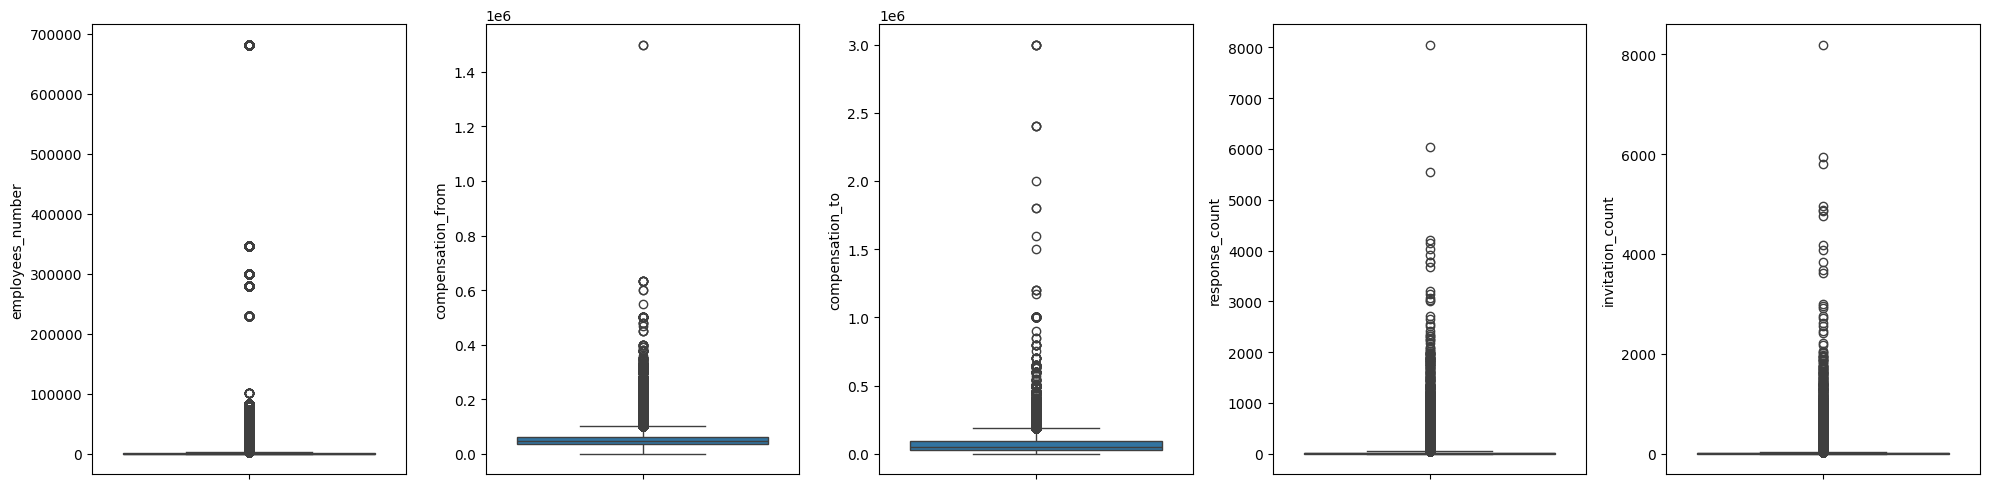

In [91]:
fig, axis = plt.subplots(1, 5, figsize=(20, 5))

sns.boxplot(data=data['employees_number'], ax=axis[0])
sns.boxplot(data=data['compensation_from'], ax=axis[1])
sns.boxplot(data=data['compensation_to'], ax=axis[2])
sns.boxplot(data=data['response_count'], ax=axis[3])
sns.boxplot(data=data['invitation_count'], ax=axis[4])

plt.tight_layout()
plt.show()

#### Выбросов не так много в отношении всего датасета, поэтому будем удалять их по методу 3-х сигм, а не заменять

In [92]:
garbage = []

for num_col in num_cols:
    upper_bound = data[num_col].quantile(0.975)
    if 'compensation' in num_col:
        lower_bound = data[data[num_col] != 0][num_col].quantile(0.003)
        ejections = data[(data[num_col] > upper_bound) | (data[num_col] < lower_bound) & (data[num_col] != 0)]
    else:
        ejections = data[data[num_col] > upper_bound]

    garbage.extend(ejections.index.tolist())

garbage = list(set(garbage))
data = data.drop(garbage).reset_index(drop=True)

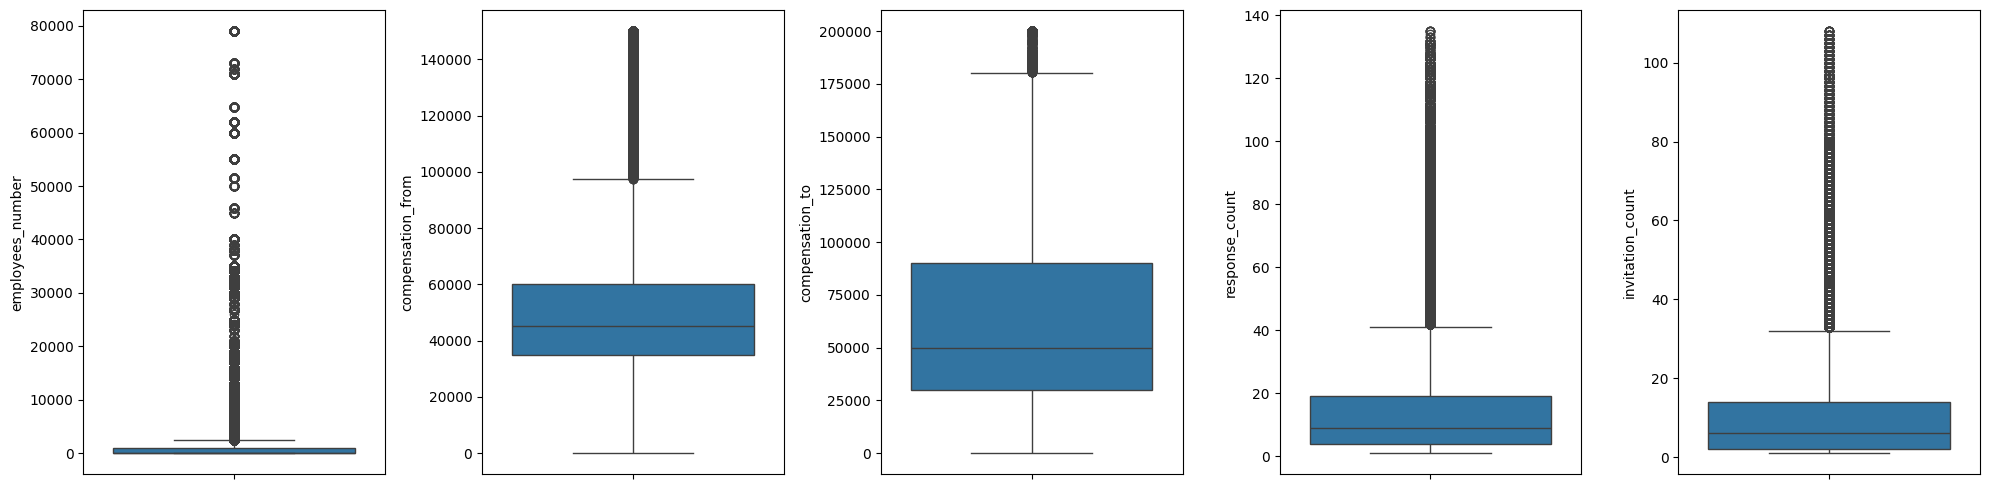

In [93]:
fig, axis = plt.subplots(1, 5, figsize=(20, 5))

sns.boxplot(data=data['employees_number'], ax=axis[0])
sns.boxplot(data=data['compensation_from'], ax=axis[1])
sns.boxplot(data=data['compensation_to'], ax=axis[2])
sns.boxplot(data=data['response_count'], ax=axis[3])
sns.boxplot(data=data['invitation_count'], ax=axis[4])

plt.tight_layout()
plt.show()

Можно сделать ложный вывод, что выбросов стало только больше, однако это уже новое распределение, а от настоящих выбросов мы избавились

In [94]:
round(1 - data.shape[0] / original_shape[0], 3)

0.136

Итого было потеряно менее 15% датасета, что приемлимо

# Удаление некорректных данных

### Нами было обнаружено несоответствие количеств откликов и/или приглашений

In [95]:
len(data[data['response_count'] != data['female_response_count'] + data['male_response_count']])

5879

In [96]:
len(data[data['young_response_count'] != data['young_female_response_count'] + data['young_male_response_count']])

16

In [97]:
len(data[data['invitation_count'] != data['female_invitation_count'] + data['male_invitation_count']])

2713

In [98]:
len(data[data['young_invitation_count'] != data['young_female_invitation_count'] + data['young_male_invitation_count']])

8

In [99]:
data = data[data['response_count'] == data['female_response_count'] + data['male_response_count']]
data = data[data['young_response_count'] == data['young_female_response_count'] + data['young_male_response_count']]
data = data[data['invitation_count'] == data['female_invitation_count'] + data['male_invitation_count']]
data = data[data['young_invitation_count'] == data['young_female_invitation_count'] + data['young_male_invitation_count']]

### Также проверим, что количество всех приглашенных больше количества молодых приглашенных

In [100]:
all(data['response_count'] >= data['young_response_count']), all(data['invitation_count'] >= data['young_invitation_count'])

(True, True)

### Данные неточности показывали некорректность данных, поэтому их мы удалили, а не заменили

# Удаление дубликатов

На дубликатах строится наш исследовательский вопрос, поэтому их мы не удаляем, глобальных же дубликатов не обнаружено

In [101]:
sum(data.duplicated())

0

# Обработка пропусков

In [102]:
data.isna().sum()[data.isnull().sum() != 0]

compensation_from     28741
compensation_to      103323
dtype: int64

Пропуски наблюдаются только в признаках, связанных с зарплатой. 

Такие пропуски объясняются нежеланием работадателя устанавливать однозначные границы зарплаты или простым игнорированием

Помимо этого так же есть много нулевых значений в compensation_from и compensation_to

In [103]:
data[data['compensation_from'] == 0].shape[0]

5559

In [104]:
data[data['compensation_to'] == 0].shape[0]

46071

Их также необходимо обратить в nan, так как 0 - это всё равно, что отсутствие данных

Мы также проверили на всякий случай, если 0 - зарплаты волонтёров, так как им не платят, но оказалось, что это не так

In [105]:
data[data['employment'] == 'volonteer']

,vacancy_id,employer_id,employees_number,creation_date,work_schedule,employment,length_of_employment,compensation_from,compensation_to,accept_teenagers,...,young_response_count,young_female_response_count,young_male_response_count,invitation_count,female_invitation_count,male_invitation_count,young_invitation_count,young_female_invitation_count,young_male_invitation_count,industry_id_list
43018,81902096,2818876,0,2023-06-14,shift,volonteer,up_to_3_years,35000.0,50000.0,False,...,0,0,0,12,4,8,0,0,0,[None]
196838,77374703,8980856,1,2023-02-24,flexible,volonteer,no_experience,NaN,NaN,False,...,0,0,0,4,0,4,0,0,0,[None]
308732,77073973,2818876,0,2023-02-16,shift,volonteer,up_to_3_years,35000.0,50000.0,False,...,0,0,0,10,0,10,0,0,0,[None]


### Также запишем новый категориальный столбец, который содержит информацию о том, содержались ли nan в зарплате

In [106]:
data[['compensation_from', 'compensation_to']] = data[['compensation_from', 'compensation_to']].replace(0, np.nan)

In [107]:
mask = data['compensation_from'].isna() | data['compensation_to'].isna()

In [108]:
data['correct_salary'] = mask.apply(lambda x: 'approximately' if x else 'correct')

In [109]:
data

,vacancy_id,employer_id,employees_number,creation_date,work_schedule,employment,length_of_employment,compensation_from,compensation_to,accept_teenagers,...,young_female_response_count,young_male_response_count,invitation_count,female_invitation_count,male_invitation_count,young_invitation_count,young_female_invitation_count,young_male_invitation_count,industry_id_list,correct_salary
0,78161908,4809555,50,2023-03-17,shift,full,no_experience,22500.0,NaN,False,...,4,1,26,26,0,2,2,0,[None],approximately
1,79496395,5667513,5,2023-04-19,shift,full,up_to_3_years,24000.0,30000.0,False,...,2,0,3,3,0,0,0,0,[None],correct
2,87102246,1072323,0,2023-09-21,full_day,full,up_to_3_years,50000.0,NaN,False,...,0,0,9,7,2,0,0,0,"[7, 8]",approximately
3,76367381,1160192,0,2023-01-30,full_day,full,up_to_3_years,55000.0,150000.0,False,...,0,0,49,39,10,0,0,0,"[5, 13]",correct
4,81516485,1025275,38000,2023-06-05,shift,full,no_experience,38500.0,56500.0,False,...,1,1,13,0,13,1,0,1,"[8, 41]",correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326322,87825374,3558,7000,2023-10-06,flyInFlyOut,full,up_to_3_years,96780.0,NaN,False,...,0,0,9,8,1,0,0,0,[50],approximately
326323,77397135,4446306,2,2023-02-27,remote,full,above_6_years,100000.0,150000.0,False,...,0,0,5,3,2,0,0,0,[7],correct
326324,75924698,2067104,0,2023-01-18,shift,full,up_to_3_years,35000.0,40000.0,False,...,0,0,34,34,0,0,0,0,[None],correct
326325,84486705,1838,0,2023-08-03,full_day,full,up_to_3_years,85000.0,NaN,False,...,0,0,1,0,1,0,0,0,[44],approximately


Теперь заменим все nans в compensation_from на медианную зарплату данной профессии. Такое решение содержит множество допущений, ведь есть множество факторов, влияющих на 'compensation_from', но 'specialization' мы посчитали наиболее значимым и достаточным (как аргумент, там нет пропусков и на каждое уникальное значение в среднем 15000 сэмплов)

Технически также можно взять медианную более мелких групп, вроде сочетаний профессии и региона, профессии и работодателя, но эти группы могут быть крайне маленькими или вообще не быть, что неинформативно, поэтому мы посчитали, что только профессии будет достаточно.

##### Также мы посчитали коэффициент корреляции eta для пар: 'compensation_from' и 'specialization', 'compensation_from' и 'region_name'

In [110]:
def get_eta_correlation(categorical_col):
    groups = [data['compensation_from'][data[categorical_col] == value] for value in data[categorical_col].unique()]
        
    total_variance = np.var(data['compensation_from'])
    group_means = [g.mean() for g in groups]
    group_sizes = [len(g) for g in groups]
    group_variance = sum(size * (mean - data['compensation_from'].mean()) ** 2 for size, mean in zip(group_sizes, group_means)) / len(data)

    return np.round(group_variance / total_variance, 3)

In [111]:
get_eta_correlation('specialization')

0.284

In [112]:
get_eta_correlation('region_name')

0.026

Заметим, что специализация влияет на зарплату гораздо значимее, чем регион

In [113]:
data['compensation_from'] = data['compensation_from'].fillna(
    data.groupby('specialization')['compensation_from'].transform('median')
)

In [114]:
'''случаи, где compensation_from > compensation_to'''

data[(data['compensation_from'] > data['compensation_to']) & (data['compensation_to'] != 0)].shape[0]

3595

Также есть данные, где compensation_from, в которой мы заполняли пропуски, больше чем compensation_to. В таких случаях мы опустим compensation_from до уровня compensation_to

In [115]:
data.loc[(data['compensation_from'] > data['compensation_to']) & (data['compensation_to'] != 0), 'compensation_from'] = data['compensation_to']

In [116]:
data['compensation_to'] = data['compensation_to'].fillna(data['compensation_from'])

In [117]:
sum(data.isnull().sum())

0

# Дополнительные колонки

Добавим данные о длине списка id индустрий

In [118]:
data['industry_id_list'] = data['industry_id_list'].apply(eval)

In [119]:
data['length_industry_list'] = data['industry_id_list'].apply(lambda x: len(x) if int(bool(x[0])) else 0)

In [120]:
data['length_industry_list'].value_counts()

length_industry_list
0    134405
1    117551
2     54702
3     11339
4      2045
5       356
Name: count, dtype: int64

# Сохранение датасета

In [121]:
data.to_csv('cleared_data_no_exp.csv', index=False)

In [122]:
pd.read_csv('cleared_data_no_exp.csv').describe()

,vacancy_id,employer_id,employees_number,compensation_from,compensation_to,response_count,female_response_count,male_response_count,young_response_count,young_female_response_count,young_male_response_count,invitation_count,female_invitation_count,male_invitation_count,young_invitation_count,young_female_invitation_count,young_male_invitation_count,length_industry_list
count,3.203980e+05,3.203980e+05,320398.000000,320398.000000,320398.000000,320398.000000,320398.000000,320398.000000,320398.000000,320398.000000,320398.000000,320398.000000,320398.000000,320398.000000,320398.000000,320398.000000,320398.000000,320398.000000
mean,8.353531e+07,3.545894e+06,4282.710479,51555.418336,65087.669118,14.805548,8.505109,6.300439,0.754371,0.487931,0.266440,10.595038,6.019048,4.575990,0.295211,0.189876,0.105335,0.845611
std,4.566648e+06,3.131684e+06,13581.514214,25673.403819,36783.580468,16.768250,13.188451,8.473087,1.777006,1.340252,0.740924,13.228883,10.134623,7.715988,0.835033,0.633037,0.395309,0.884972
min,7.453818e+07,6.000000e+00,0.000000,3000.000000,3000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.959668e+07,8.994620e+05,1.000000,35000.000000,40000.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.359738e+07,2.958557e+06,50.000000,45000.000000,50000.000000,9.000000,4.000000,3.000000,0.000000,0.000000,0.000000,5.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000
75%,8.764934e+07,5.195559e+06,1000.000000,60000.000000,80000.000000,19.000000,10.000000,8.000000,1.000000,0.000000,0.000000,14.000000,7.000000,5.000000,0.000000,0.000000,0.000000,1.000000
max,9.116080e+07,1.123034e+07,79000.000000,150000.000000,200000.000000,135.000000,93.000000,60.000000,17.000000,12.000000,6.000000,108.000000,71.000000,55.000000,8.000000,5.000000,3.000000,5.000000
